In [1]:
# import the necessary packages
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.optimizers import SGD
from loader_util.nn.conv import LeNet
from loader_util.utils.captchahelper import preprocess
from imutils import paths
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.axes._axes as axes
import cv2
import os
sns.set()

In [2]:
# construct the arg parser
args = {
    'dataset': './dataset',
    'model': './'
}

# initialise the data and labels
data = []
labels = []

# loop over the input images
for imagePath in paths.list_images(args['dataset']):
    # load the image, preprocess it and store it in the data list
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = preprocess(image, width=28, height=28)
    image = np.expand_dims(image, axis=-1)
    image - img_to_array(image)
    data.append(image)
    
    # extyract the class labels
    label = imagePath.split(os.path.sep)[-2]
    labels.append(label)

# scale the raw pixel intensities to [0,1]
data = np.array(data, dtype='float') / 255.0
labels = np.array(labels)

In [3]:
# partition the data into train test sets
trainx, testx, trainy, testy = train_test_split(data, labels,
                                                test_size=0.25,
                                                random_state=42)

# convert the labels from integers to vectors
lb = LabelBinarizer()
trainy = lb.fit_transform(trainy)
testy = lb.transform(testy)

In [4]:
# initialise the model
print('[INFO] compiling model....')
model = LeNet.build(width=28, height=28, depth=1, classes=9)
opt = SGD(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=opt, 
              metrics=['accuracy'])
model.summary()

[INFO] compiling model....
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 20)        520       
_________________________________________________________________
activation (Activation)      (None, 28, 28, 20)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 20)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 50)        25050     
_________________________________________________________________
activation_1 (Activation)    (None, 14, 14, 50)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 50)          0         
_________________________________________________________________
flatten (Flatten)            

In [5]:
# train the network
print('[INFO] training network ......')
H = model.fit(trainx, trainy, validation_data=(testx, testy),
              batch_size=32, epochs=20, verbose=1)

# evaluate the network
preds = model.predict(testx, batch_size=32)
print(classification_report(testy.argmax(axis=1), 
                             preds.argmax(axis=1), target_names=lb.classes_))

# save model to disk
model.save(args['model'])

[INFO] training network ......
Train on 1509 samples, validate on 503 samples
Epoch 1/20
1509/1509 [==============================] - 12s 8ms/sample - loss: 2.1611 - accuracy: 0.1836 - val_loss: 2.1663 - val_accuracy: 0.0855
Epoch 2/20
1509/1509 [==============================] - 1s 385us/sample - loss: 2.0948 - accuracy: 0.3552 - val_loss: 2.0665 - v

In [6]:
epochs = range(1,21)
loss = H.history['loss']
accuracy = H.history['accuracy']
val_loss = H.history['val_loss']
val_accuracy = H.history['val_accuracy']
plot_df = pd.DataFrame(data=np.c_[epochs,loss,accuracy,val_loss,val_accuracy], 
                       columns=['epochs','loss', 'accuracy', 'val_loss', 'val_accuracy'])

### Plot training and validation loss and accuracy curves

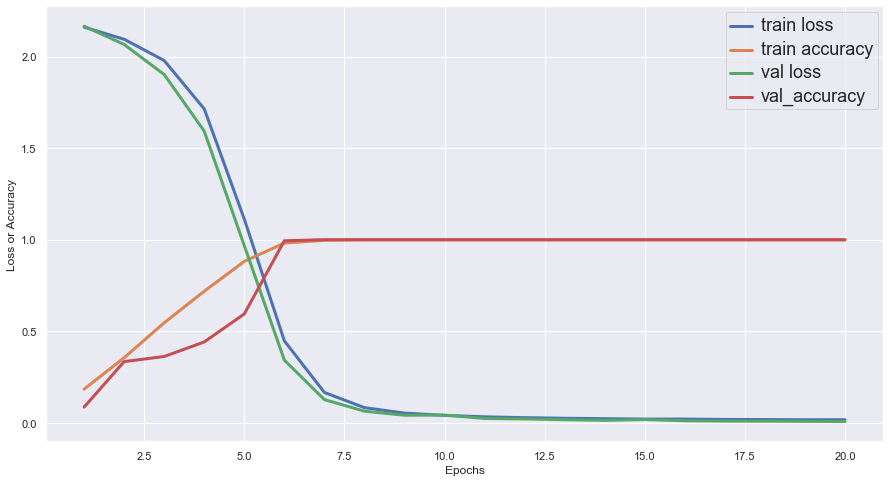

In [7]:
sns.set(font_scale=1)
f, ax = plt.subplots(1, 1, figsize=(15,8))
sns.lineplot(data=plot_df, x='epochs', y='loss', ax=ax, label='train loss', linewidth=3)
sns.lineplot(data=plot_df, x='epochs', y='accuracy', ax=ax, label='train accuracy', linewidth=3)
sns.lineplot(data=plot_df, x='epochs', y='val_loss', ax=ax, label='val loss', linewidth=3)
sns.lineplot(data=plot_df, x='epochs', y='val_accuracy', ax=ax, label='val_accuracy', linewidth=3)
ax.set_ylabel('Loss or Accuracy')
ax.set_xlabel('Epochs')
plt.setp(ax.get_legend().get_texts(), fontsize='18'); # for legend text